In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time

import MPO_hyperparameter_v2
import MPO_tt_v2
import MPO_inference_v2
import MPO_train_v2 as MPO

import activation_functions as act
import contractions as con

In [2]:
def weights_to_MPO(weights, D, sigma, sigma_prime, layer):
    # Reshape weights, order of indices are an assumption and may need to be modified
    MPO = []
    num_sites = len(sigma)
    starting_site = layer*(num_sites+1)  # +1 to skip bias

    for i in range(num_sites):
        # sigma'*D_right, D_left*sigma
        if i == 0:
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_right, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        elif i != 0 and i != num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, D, sigma[i]))
            # Need shape (D_left, D_right, sigma, sigma')
            site = np.transpose(site, (2, 1, 3, 0))
        elif i == num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_left, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        MPO.append(site)
    bias = weights[num_sites+starting_site]
    return MPO, bias

In [3]:
def FC2(MPO_0, bias_0, MPO_1, bias_1):
    data = input_data.read_data_sets("./data/",validation_size=0,one_hot=True)
    
    start = time.time()

    temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
    temp = con.contract_horizontal(temp, MPO_0[2], 'right')
    layer_0 = con.contract_horizontal(temp, MPO_0[3], 'right')

    temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
    temp = con.contract_horizontal(temp, MPO_1[2], 'right')
    layer_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

    end = time.time()

    total = 10000
    correct = 0
    for i in range(0, total):
        t0 = time.time()
        xW_1 = data.test.images[i] @ layer_0 + bias_0
        xW_1 = act.ReLU(xW_1)
        result = xW_1 @ layer_1 + bias_1
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    return correct/total*100, end-start

In [4]:
def close_legs(MPO):
    MPS = []
    for i, site in enumerate(MPO):
        if i == 0 or i == len(MPO)-1:
            site = np.reshape(site, (site.shape[0], site.shape[1]*site.shape[2])).T
        else:
            site = np.reshape(site, (site.shape[0], site.shape[1], site.shape[2]*site.shape[3]))
        MPS.append(site)
    return MPS

def open_legs(MPS, MPO_orig, bond_dim):
    MPO = []
    for i, site in enumerate(MPS):
        if i == 0 or i == len(MPS)-1:
            site = np.reshape(site.T, (bond_dim[i], MPO_orig[i].shape[1], MPO_orig[i].shape[2]))
        else:
            site = np.reshape(site, (bond_dim[i-1], bond_dim[i], MPO_orig[i].shape[2], MPO_orig[i].shape[3]))
        MPO.append(site)
    return MPO

In [5]:
import compression as comp
import metrics
import math
import matplotlib.pyplot as plt
import initializations as init
import canonical_forms as can

def initialize_random_MPS_changing_phys_dim(phys_dim, num_sites, bond_dim):
    MPS = []
    M_1 = np.random.rand(phys_dim[0], bond_dim)
    MPS.append(M_1)
    for i in range(1, num_sites-1):
        M_i = np.random.rand(bond_dim, bond_dim, phys_dim[i])
        MPS.append(M_i)
    M_N = np.random.rand(phys_dim[-1], bond_dim)
    MPS.append(M_N)
    #MPS = [M_1] + [M_i]*(num_sites-2) + [M_N]
    MPS, _ = can.left_normalize(MPS)
    MPS, _ = can.right_normalize(MPS)
    return MPS

def compress_NN(raw_state, phys_dim, threshold, compressed_state=0, plot=0):
    """ Right normalizes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

    Args:
        raw_state: MPS to be compressed
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    compressed_state = initialize_random_MPS_changing_phys_dim(phys_dim, num_sites=len(raw_state), bond_dim=1)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]
    max_bond_dim = 1
    # compressed_state = init.initialize_random_normed_state_MPS(len(raw_state),
    #                                                             bond_dim=max_bond_dim,
    #                                                             phys_dim=raw_state[0].shape[0])
    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    best_dist = []
    best_sim = []
    compressions = []
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            best_dist.append((metrics.overlap(compressed_state, raw_state)))
            best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", best_sim[-1], "Dist:", best_dist[-1], "BondDim:", max_bond_dim)
            compressions.append(compressed_state[:])

            # Break if we cannot increase bond dimension anymore
            if max_bond_dim+1 == bond_dim_raw_state:
                break

            # Break if changing bond dimension did not do enough
            if len(best_dist) > 1 and np.abs(best_dist[-2]-best_dist[-1] < threshold):
                break

            # Update each tensor by increasing bond dimension
            for i, tensor in enumerate(compressed_state):
                if tensor.ndim == 2:
                    new_tensor = np.zeros((tensor.shape[0], tensor.shape[1]+1))
                    new_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
                    compressed_state[i] = new_tensor

                elif tensor.ndim == 3:
                    new_tensor = np.zeros((tensor.shape[0]+1, tensor.shape[1]+1, tensor.shape[2]))
                    new_tensor[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
                    compressed_state[i] = new_tensor
            max_bond_dim = compressed_state[math.ceil(len(compressed_state)/2)].shape[0]

    if plot == 1:
        max_bond_dim = range(1, len(best_dist)+1)

        plt.figure()
        plt.title("Euclidean Distance vs. Max Bond Dimension")
        plt.xlabel("Max Bond Dimension")
        plt.ylabel("Euclidean Distance")
        plt.plot(max_bond_dim, best_dist)

    return compressions, best_dist, best_sim

In [6]:
def calculate_params(data):
    params = 0
    for tensor in data:
        params += tensor.size

    return params

# Pre-processing

## 1. Train

In [7]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = MPO.main()

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.1977
Accuracy at step 1: 0.3114
Accuracy at step 2: 0.3643
Accuracy at step 4: 0.5243
Accuracy at step 5: 0.591
Guessing
After 7 trainning step(s),best accuracy=0.591


## 2. Open weights matrices into correct MPO

In [8]:
D = 8
sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

In [9]:
D = 8
sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

## 3. Check that MPO is correct based on accuracy from model

In [10]:
acc, t = FC2(MPO_0, bias_0, MPO_1, bias_1)
print(acc, "%", t, "s")

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
59.099999999999994 % 0.0059697628021240234 s


## 4. Close legs to use for compression algorithm

In [11]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)

# Compression tests

## 1. Compress MPS layers

In [12]:
compressed_MPS_0, dist, sim = compress_NN(MPS_0, phys_dim=[16, 28, 28, 16], threshold=1e-6, plot=0)

Sim: 13.959046772537386 Dist: 16.50565861199558 BondDim: 1
Sim: 40.19272104346024 Dist: 15.690860140375383 BondDim: 2
Sim: 85.198130551885 Dist: 14.184416887429537 BondDim: 3
Sim: 131.90371205008657 Dist: 12.429485143729599 BondDim: 4
Sim: 181.42400681988852 Dist: 10.24557495548164 BondDim: 5
Sim: 225.82060488604924 Dist: 7.783007651430909 BondDim: 6
Sim: 257.6950815894073 Dist: 5.357306356638011 BondDim: 7


In [13]:
compressed_MPS_1, dist, sim = compress_NN(MPS_1, phys_dim=[4, 40, 4, 4], threshold=1e-6, plot=0)

Sim: 9.745508399182256 Dist: 5.863674349163205 BondDim: 1
Sim: 20.916248875510597 Dist: 4.817876751921559 BondDim: 2
Sim: 31.95324716322343 Dist: 3.4892603956989707 BondDim: 3
Sim: 39.56545350773527 Dist: 2.1360551876020226 BondDim: 4
Sim: 41.92387901408268 Dist: 1.48469062707828 BondDim: 5
Sim: 43.170984497847826 Dist: 0.9783663804367861 BondDim: 6
Sim: 43.81842833039585 Dist: 0.5565581207933018 BondDim: 7


In [14]:
print("Orig:", calculate_params(MPS_0))
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/calculate_params(MPS_0)*100, 2), "% of Orig")

Orig: 3840
1 2.29 % of Orig
2 7.5 % of Orig
3 15.62 % of Orig
4 26.67 % of Orig
5 40.62 % of Orig
6 57.5 % of Orig
7 77.29 % of Orig


In [15]:
print("Orig:", calculate_params(MPS_1))
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/calculate_params(MPS_1)*100, 2), "% of Orig")

Orig: 2880
1 1.81 % of Orig
2 6.67 % of Orig
3 14.58 % of Orig
4 25.56 % of Orig
5 31.67 % of Orig
6 37.78 % of Orig
7 43.89 % of Orig


## 2. Check accuracy for each compressed dimension

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

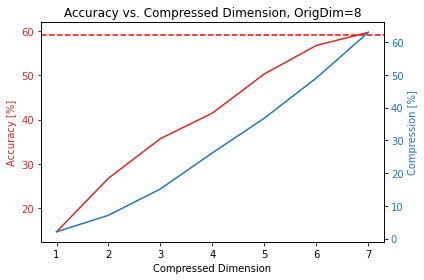

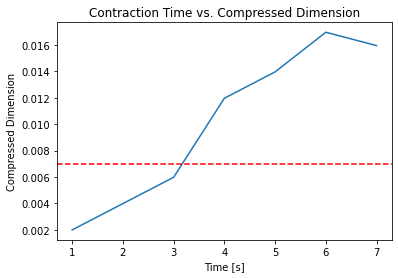

In [16]:
### Maximizing total accuracy
acc_compressed = []
time_compressed = []
params = []
if len(compressed_MPS_0) > len(compressed_MPS_1):
    shortest = len(compressed_MPS_1)
    longest = len(compressed_MPS_0)
else:
    shortest = len(compressed_MPS_0)
    longest = len(compressed_MPS_1)

for new_dim in range(1, longest+1):
    if new_dim < shortest:
        MPS_0_test = compressed_MPS_0[new_dim-1]
        MPS_1_test = compressed_MPS_1[new_dim-1]
    else:
        if shortest == len(compressed_MPS_0):
            MPS_0_test = compressed_MPS_0[-1]
            MPS_1_test = compressed_MPS_1[new_dim-1]
        elif shortest == len(compressed_MPS_1):
            MPS_0_test = compressed_MPS_0[new_dim-1]
            MPS_1_test = compressed_MPS_1[-1]

    dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
    dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
    MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
    MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

    total_params = 0
    for tensor in MPO_0_test:
        total_params += tensor.size
    for tensor in MPO_1_test:
        total_params += tensor.size
    params.append(total_params)

    acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

params_orig = 0
for tensor in MPO_0:
    params_orig += tensor.size
for tensor in MPO_1:
    params_orig += tensor.size

params = np.array(params)/params_orig*100
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)


x = range(1, len(compressed_MPS_0)+1)
data1 = acc
data2 = params

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Accuracy [%]', color=color)
ax1.plot(x, acc_compressed, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(acc_orig, color='r', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))

fig.tight_layout()
plt.show()

plt.figure()
plt.plot(x, time_compressed)
plt.title('Contraction Time vs. Compressed Dimension')
plt.xlabel('Time [s]')
plt.ylabel('Compressed Dimension')
plt.axhline(time_orig, color='r', linestyle='--')

## 3. Check accuracy when compressing one layer at a time

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

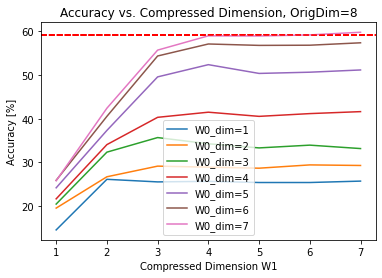

In [17]:
### Check changes in W1 for constant W0
plt.figure()
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_compressed = []
    time_compressed = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
    plt.axhline(acc_orig, color='r', linestyle='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))
    plt.xlabel('Compressed Dimension W1')
    plt.ylabel('Accuracy [%]')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

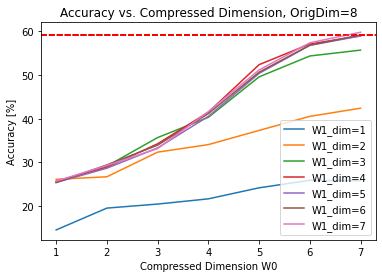

In [18]:
### Check changes in W0 for constant W1
plt.figure()
for W1_dim in range(1, len(compressed_MPS_1)+1):
    acc_compressed = []
    time_compressed = []
    MPS_1_test = compressed_MPS_1[W1_dim-1]
    for W0_dim in range(1, len(compressed_MPS_0)+1):
        MPS_0_test = compressed_MPS_0[W0_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)


    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W1_dim=%d" % W1_dim)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.axhline(acc_orig, color='r', linestyle='--')
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_1)+1))
    plt.xlabel('Compressed Dimension W0')
    plt.ylabel('Accuracy [%]')

## Heatmap

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t1

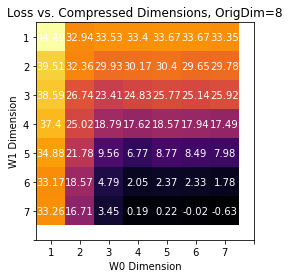

In [19]:
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
heatmap = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    loss = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

        acc, _ = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        loss.append(acc_orig-acc)
    heatmap.append(loss)

fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap='inferno')

# We want to show all ticks...
ax.set_xticks(np.arange(len(compressed_MPS_0)+1))
ax.set_yticks(np.arange(len(compressed_MPS_1)+1))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

plt.xlabel('W0 Dimension')
plt.ylabel('W1 Dimension')
plt.title('Loss vs. Compressed Dimensions, OrigDim=%d' % D)
# Loop over data dimensions and create text annotations.
for i in range(len(compressed_MPS_0)):
    for j in range(len(compressed_MPS_1)):
        text = ax.text(j, i, np.round(heatmap[i][j], 2),
                       ha="center", va="center", color="w")